<a href="https://colab.research.google.com/github/SBryanK/Recommendation-System/blob/main/Recommendation_Systems_Learner_Notebook_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
df = pd.read_csv('/content/ratings_Electronics.csv', header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

In [ ]:
df.shape

(206397, 3)

**As this dataset is very large and has 206,397 observations with 3 columns, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df_copy.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1


In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df_copy.loc[ ~ df_copy.user_id.isin(remove_users)]

In [ ]:
prods = df_copy.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1


In [ ]:
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df_copy.loc[~ df_copy.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head(10)

,user_id,prod_id,rating
5,A1QGNMC6O1VW39,0511189877,5.0
6,A3J3BRHTDRFJ2G,0511189877,2.0
7,A2TY0BTJOTENPG,0511189877,5.0
8,A34ATBPOK6HCHY,0511189877,5.0
9,A89DO69P0XZ27,0511189877,5.0
10,AZYNQZ94U6VDB,0511189877,5.0
11,A1DA3W4GTFXP6O,0528881469,5.0
12,A29LPQQDG7LD5J,0528881469,1.0
13,AO94DHGC771SJ,0528881469,5.0
14,AMO214LNFCEI4,0528881469,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [ ]:
df_final.shape

(190864, 3)

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.describe


<bound method NDFrame.describe of                user_id     prod_id  rating
5       A1QGNMC6O1VW39  0511189877     5.0
6       A3J3BRHTDRFJ2G  0511189877     2.0
7       A2TY0BTJOTENPG  0511189877     5.0
8       A34ATBPOK6HCHY  0511189877     5.0
9        A89DO69P0XZ27  0511189877     5.0
...                ...         ...     ...
206392  A3VASNAKXWEEOJ  B00006LK1Q     3.0
206393  A2SZBKSRDY7S3A  B00006LK1Q     4.0
206394  A2GOTG5FKZLBMX  B00006LK1Q     5.0
206395  A195UY431STUI9  B00006LK1Q     2.0
206396  A1UQW5NL4J2VB4  B00006LK1Q     4.0

[190864 rows x 3 columns]>

**
From the original dataset we have converted the new dataset into 206397 rows which includes users with min 50 ratings.
> Indented block



### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190864 entries, 5 to 206396
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  190864 non-null  object 
 1   prod_id  190864 non-null  object 
 2   rating   190864 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.8+ MB


**There are 2 Object data type and 1 float data type**

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**There are no missing data i.e. null values.**

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    190864.000000
mean          4.024583
std           1.366968
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

**:
The mean of the reating is 4.0 with standard deviation of 1.37, this indicates quiet high rating in overall product with relatively small deviation.
Moreover, Rating 5.0 is been more popular rating across different users, more than 75% of the data contains top rating as 5.0. That means users are more satisfied with the products and giving postive ratings.**

### **Checking the rating distribution**

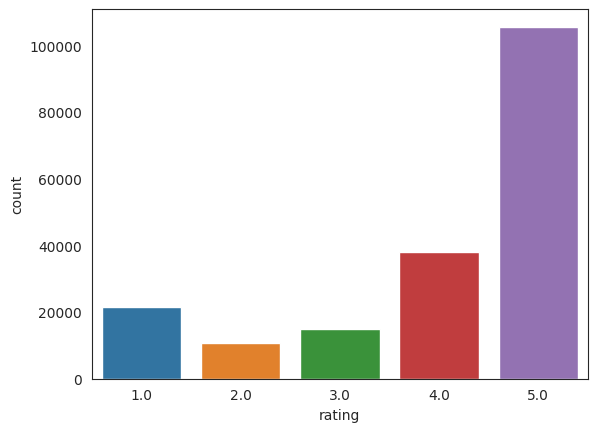

In [ ]:
# Create the bar plot and provide observations
with sns.axes_style('white'):
    g = sns.countplot( x= "rating", data = df_final)

**As per the rating distribution shows, 5.0 shows dominant and most of the users provided positive rating.**

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
#Total users in the data
print('Total number of users in the data : ',df_final['user_id'].value_counts().sum())

#Total Products in the data
print('Total number of Products in the data : ',df_final['prod_id'].value_counts().sum())

# Number of unique user id  in the data
print('Number of unique users in Raw data = ', df_final['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', df_final['prod_id'].nunique())

Total number of users in the data :  190864
Total number of Products in the data :  190864
Number of unique users in Raw data =  167440
Number of unique product in Raw data =  5485


There is about half unique data in the raw data**

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final.groupby('user_id').size().sort_values(ascending=False)[:10]

user_id
A231WM2Z2JL0U3    167
A5JLAU2ARJ0BO      79
AT2J7H5TRZM8Z      52
A6FIAB28IS79       43
A1MJMYLRTZ76ZX     43
A2BGZ52M908MJY     38
A1RPTVW5VEOSI      35
A2AEZQ3DGBBLPR     34
AY8Q1X7G96HV5      32
A2R6RA8FRBS608     30
dtype: int64

**Write your observations here:Observations :

A231WM2Z2JL0U3 has mot number of ratings i.e. 194.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
df_final.groupby('prod_id')['rating'].mean()

# Sort the dataframe by average of ratings in the descending order


# See the first five records of the "final_rating" dataset


prod_id
0511189877    4.500000
0528881469    2.851852
0594012015    2.000000
0594033896    4.400000
0594033926    4.533333
                ...   
B00006LIN8    4.400000
B00006LIOM    4.000000
B00006LK1O    3.460317
B00006LK1P    2.888889
B00006LK1Q    3.933333
Name: rating, Length: 5485, dtype: float64

In [ ]:
# Calculate the count of ratings for each product
df_final.groupby('prod_id')['rating'].count().sort_values(ascending = False)

prod_id
B00004ZCJE    2547
B00001P4ZH    2075
B000065BP9    1714
B00004T8R2    1692
B00001WRSJ    1586
              ... 
B000059RAB       5
B00006HODY       5
B00006HODZ       5
B000056SL6       5
B00005LL6C       5
Name: rating, Length: 5485, dtype: int64

In [ ]:
# Create a dataframe with calculated average and count of ratings
final_rating_df = pd.DataFrame()
final_rating_df['avg_rating'] = pd.DataFrame(df_final.groupby('prod_id')['rating'].mean())

In [ ]:
#Adding rating_counts to the new df i.e. final_rating_df
final_rating_df['rating_counts'] = pd.DataFrame(df_final.groupby('prod_id')['rating'].count().sort_values(ascending = False))

In [ ]:
final_rating_df.head()

,avg_rating,rating_counts
prod_id,,
0511189877,4.500000,6
0528881469,2.851852,27
0594012015,2.000000,8
0594033896,4.400000,5
0594033926,4.533333,15


In [ ]:
def top_n_products(final_rating, n, min_interaction):

    #Finding movies with minimum number of interactions
    recommendations = final_rating_df[final_rating_df['rating_counts'] >= min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating_df, 5, 50))

['B000053HC5', 'B00005LE76', 'B00006I53W', 'B00005UKBD', 'B000053HH5']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating_df, 5, 100))

['B000053HC5', 'B00006I53W', 'B000053HH5', 'B00004TDLD', 'B00006I53X']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
from surprise import KNNBasic
algo = KNNBasic()
sim_options = {'name': 'cosine',
               'user_based': True}


# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knnBasic_init = KNNBasic(sim_options=sim_options,verbose=False, random_state = 1)

# Fit the model on the training data
knnBasic_init.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knnBasic_init, 10, 3.5)

**The RMSE of 1.0012 is relatively low, which means that the model is generally making accurate predictions. The precision of 0.855 and recall of 0.858 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.856 is a good indication that the model is performing well overall**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
knnBasic_init.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
filtered_df = df_final[df_final["prod_id"] != "1400501466"]

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
unique_user_ids = filtered_df["user_id"].unique()

print(unique_user_ids)

**The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.29. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was impossible (was_impossible) and the reason why it was impossible (reason='Not enough neighbors').

This means that the model was unable to make a prediction for this user-item pair because there were not enough other users who had rated both the item and the user. This can happen when a user has rated very few items, or when the item is new and has not yet been rated by many users.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],'sim_options': {'name': ['msd', 'cosine','pearson'],'user_based': [True]}}
# Performing 3-fold cross-validation to tune the hyperparameters
fold3_grid = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
# Fitting the data
fold3_grid.fit(data)
# Best RMSE score
print(fold3_grid.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(fold3_grid.best_params['rmse'])

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_sim_user = KNNBasic(sim_options=sim_options, k=20, min_k=3,verbose=False)
# Training the algorithm on the trainset
optimized_sim_user.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(optimized_sim_user , 10, 3.5)

**The RMSE of 0.9593 is relatively high, which means that the model is not making very accurate predictions. The precision of 0.855 and recall of 0.881 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.868 is a good indication that the model is performing well overall.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
optimized_sim_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_sim_user.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

**From the True Rating 5 , our base model has predicted 3.4. But, our Optimized model has predicted as 4.85. There is defintely significant increase**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
optimized_sim_user.get_neighbors(0, k=5)

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, optimized_sim_user)
print(recommendations)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df.head()

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item_item = KNNBasic(sim_options=sim_options,verbose=False)
# Train the algorithm on the trainset, and predict ratings for the test set
knn_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item_item , 10, 3.5)

**The RMSE of 0.9950 is relatively high, which means that the model is not making very accurate predictions. The precision of 0.838 and recall of 0.845 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.841 is a good indication that the model is performing well overall.**

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
knn_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

**The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.27. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the actual rating of the item (actual_k) and whether or not the prediction was impossible (was_impossible). In this case, the actual rating of the item is 22 and the prediction was not impossible.**

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
knn_item_item.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

**The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.29. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was impossible (was_impossible) and the reason why it was impossible (reason='Not enough neighbors')**

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30], 'min_k': [3],'sim_options': {'name': ['msd', 'cosine',],'user_based': [False]}}
# Performing 3-fold cross validation to tune the hyperparameters
fold3_grid_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
# Fitting the data
fold3_grid_item.fit(data)
# Find the best RMSE score
print(fold3_grid_item.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(fold3_grid_item.best_params['rmse'])

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options={'name': 'msd', 'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=3,verbose=False)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)
# predicting ratings for the testset
predictions = sim_item_item_optimized.test(testset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized, 10, 3.5)

**The RMSE of 0.9648 is relatively high, which means that the model is not making very accurate predictions. The precision of 0.837 and recall of 0.868 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.852 is a good indication that the model is performing well overall.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

**Not much improvmenet , compared to the previous models**



### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k=5)

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)
print(recommendations)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df1 = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df1.head()

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd_factorization = SVD()
# Training the algorithm on the trainset
svd_factorization.fit(trainset)
# predicting ratings for the testset
predictions = svd_factorization.test(testset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_factorization, 10, 3.5)

**The RMSE of 0.8897 is relatively low, which means that the model is making accurate predictions. The precision of 0.852 and recall of 0.878 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.865 is a good indication that the model is performing well overall.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd_factorization.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

**The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.20. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was possible (was_impossible=False)._**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd_factorization.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

**The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.17. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was possible (was_impossible=False)**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
fold3_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
# Fitting data
fold3_gs.fit(data)
# Best RMSE score
print(fold3_gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(fold3_gs.best_params['rmse'])

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_factor_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)
# Train the algorithm on the trainset
svd_factor_optimized.fit(trainset)
 # predicting ratings for the testset
predictions = svd_factor_optimized.test(testset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_factor_optimized, 10, 3.5)

**The RMSE of 0.8814 is relatively low, which means that the model is making accurate predictions. The precision of 0.853 and recall of 0.874 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.863 is a good indication that the model is performing well overall.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_factor_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_factor_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

We have tried totall three recommendation systems.

Rank-based using averages (User - User)
similarity-based collaborative filtering (Item - Item)
model-based (matrix factorization) collaborative filtering
We have also tried to predict the user rating for all these recommendation models as well.
User-User model has the better RMSE after the hyperparamter tuning with optimzation , it gave reduced RMSE value and also predicted the user rating accurately i.e. 4.85 , which is close to the tru rating 5. This defintely had the better prediction compared to the other two models. However if we consider the other models RMSE - Matrix factorization model had lowest RMSE value as 0.88 , this was the better RMSE compared to the other two models.
After tuning the model in Item-Item similarity model & Matrix factorization didn't help much in terms of the prediction and accuracy.
Overall all recommendation systems are reasonable enough to predict and nothing in particular was outstanding model to rely on.